In [2]:
#Libraries

import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

%matplotlib inline

## Data

In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-17 19:38:23--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 198.18.7.66
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|198.18.7.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M   161KB/s    in 8.7s    

2022-10-17 19:38:34 (161 KB/s) - ‘housing.csv’ saved [1423529/1423529]



In [4]:
Cols= ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
       "median_income", "median_house_value", "ocean_proximity"]

df= pd.read_csv('housing.csv', usecols= Cols)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# Fill NAs with 0
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
df['total_bedrooms']= df['total_bedrooms'].fillna(0)

In [8]:
# Apply the log tranform to median_house_value

df['median_house_value']= np.log(df['median_house_value'])

In [9]:
# Do train/validation/test split with 60%/20%/20% distribution
# Use the train_test_split function and set the random_state parameter to 1.

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.median_house_value.values
y_test = df_test.median_house_value.values
y_val = df_val.median_house_value.values

del df_train['median_house_value']
del df_test['median_house_value']
del df_val['median_house_value']

In [10]:
# Use DictVectorizer to turn the dataframe into matrices

dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
x_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
x_val = dv.fit_transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

- Train a model with max_depth=1

Which feature is used for splitting the data?

In [11]:
#Train the model

model_dt = DecisionTreeRegressor(max_depth=1)
model_dt.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(export_text(model_dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/ariahadid/.local/share/virtualenvs/churn-flask-app-GXXnzVri/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


> Answer: ocean_proximity

## Question 2

Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

In [16]:
# Train the model

model_rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model_rf.fit(x_train, y_train)
y_pred = model_rf.predict(x_val)

In [27]:
print(f"RMSE = {mean_squared_error(y_val,y_pred,squared=False)}")

RMSE = 0.2453508692239376


## Question 3

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

In [28]:
for estimator in range(10,200,10):
    rf = RandomForestRegressor(n_estimators=estimator,
                           random_state=1,
                           n_jobs=-1)
    rf.fit(x_train,y_train)
    y_pred = rf.predict(x_val)
    print(f"RMSE for n_estimator :{estimator} = {mean_squared_error(y_pred,y_val,squared=False)}")
    

RMSE for n_estimator :10 = 0.24535086922393762
RMSE for n_estimator :20 = 0.23896578156353054
RMSE for n_estimator :30 = 0.2353358017117479
RMSE for n_estimator :40 = 0.23449118937187777
RMSE for n_estimator :50 = 0.23301531944286358
RMSE for n_estimator :60 = 0.23267986818198144
RMSE for n_estimator :70 = 0.2321928944574038
RMSE for n_estimator :80 = 0.23223073917189815
RMSE for n_estimator :90 = 0.23194861917758272
RMSE for n_estimator :100 = 0.231821021330001
RMSE for n_estimator :110 = 0.23162112873512114
RMSE for n_estimator :120 = 0.23168895040062046
RMSE for n_estimator :130 = 0.23174053318575405
RMSE for n_estimator :140 = 0.23164803817121402
RMSE for n_estimator :150 = 0.23158266014959872
RMSE for n_estimator :160 = 0.2315713768887062
RMSE for n_estimator :170 = 0.23150498712414813
RMSE for n_estimator :180 = 0.2316523136443702
RMSE for n_estimator :190 = 0.23167369683681663


> Answer: 70

## Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

What's the best max_depth:

In [29]:
for depth  in [10,15,20,25]:   
    for estimator in range(10,200,10):
        rf = RandomForestRegressor(max_depth=depth,
                                     n_estimators=estimator,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(x_train,y_train)
        y_pred = rf.predict(x_val)
        print(f"RMSE for max_depth: {depth} n_estimator :{estimator} = {mean_squared_error(y_pred,y_val,squared=False)}")

RMSE for max_depth: 10 n_estimator :10 = 0.2554911759266139
RMSE for max_depth: 10 n_estimator :20 = 0.25300113090751236
RMSE for max_depth: 10 n_estimator :30 = 0.25168021588200007
RMSE for max_depth: 10 n_estimator :40 = 0.2512530139520995
RMSE for max_depth: 10 n_estimator :50 = 0.25024947550041304
RMSE for max_depth: 10 n_estimator :60 = 0.2500771240628939
RMSE for max_depth: 10 n_estimator :70 = 0.24986804072010943
RMSE for max_depth: 10 n_estimator :80 = 0.24962467370423588
RMSE for max_depth: 10 n_estimator :90 = 0.24932451551922594
RMSE for max_depth: 10 n_estimator :100 = 0.24917016145820817
RMSE for max_depth: 10 n_estimator :110 = 0.24894449427832607
RMSE for max_depth: 10 n_estimator :120 = 0.24900137382597368
RMSE for max_depth: 10 n_estimator :130 = 0.24910848119745221
RMSE for max_depth: 10 n_estimator :140 = 0.2492417239421551
RMSE for max_depth: 10 n_estimator :150 = 0.24925896377061396
RMSE for max_depth: 10 n_estimator :160 = 0.2492049104925295
RMSE for max_depth: 10

> Answer: 20

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

Train the model with these parametes:
- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)

What's the most important feature?

In [30]:
# Train the model

model_rf = RandomForestRegressor(n_estimators=10,max_depth=20, n_jobs=-1, random_state=1)
model_rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

<AxesSubplot: >

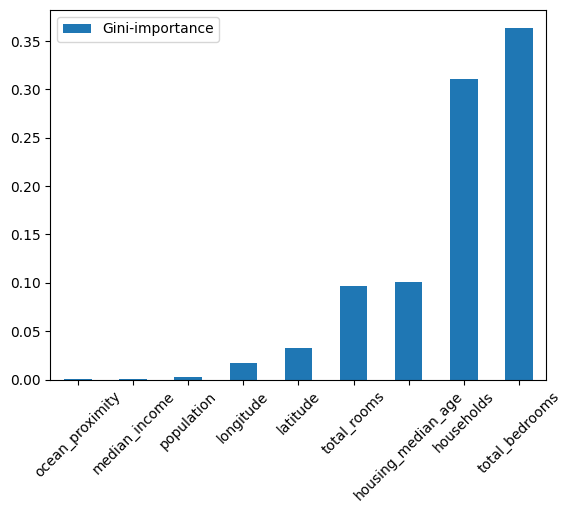

In [36]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(df_train.columns, model_rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)


> Answer: total_bedrooms

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

> xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [49]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features)
# Parameter dictionary specifying base learner
param =  {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
  
xgb_r = xgb.train(params = param, dtrain = dtrain, num_boost_round = 100)
pred = xgb_r.predict(dval)
  
# RMSE Computation
rmse = mean_squared_error(pred,y_val,squared=False)
print("RMSE : % f" %(rmse))

RMSE :  0.227837


In [46]:
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=_1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [50]:
# Parameter dictionary specifying base learner
param =  {  
    'eta': 0.1,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
  
xgb_r = xgb.train(params = param, dtrain = dtrain, num_boost_round = 100)
pred = xgb_r.predict(dval)
  
# RMSE Computation
rmse = mean_squared_error(pred,y_val,squared=False)
print("RMSE : % f" %(rmse))

RMSE :  0.232453


In [51]:
# Parameter dictionary specifying base learner
param =  {  
    'eta': 0.01,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
  
xgb_r = xgb.train(params = param, dtrain = dtrain, num_boost_round = 100)
pred = xgb_r.predict(dval)
  
# RMSE Computation
rmse = mean_squared_error(pred,y_val,squared=False)
print("RMSE : % f" %(rmse))

RMSE :  4.264994


> Answer eta 0.3